<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# Hate Speech Detector

Today you are a machine learning engineer, a member of the Birdwatch at Twitter. 

The objective of this task is to detect hate speech in tweets. For the sake of simplicity, a tweet contains hate speech if it has a racist or sexist sentiment associated with it. In other words, we need to classify racist or sexist tweets from other tweets.

A labelled dataset of 31,962 tweets (late 2017 to early 2018) is provided in the form of a compressed csv file with each line storing a tweet id, its label, and the tweet. Label '1' denotes the tweet is racist/sexist while label '0' denotes the tweet is not racist/sexist.

We will first approach the problem in a traditional approach: clean the raw text using simple regex (regular expression), extract features, build a naive Bayes models to classify tweets; then we build a deep learning model and explain our deep learning model with LIME.

## 📚 Learning Objectives

By the end of this lesson, you will be able to:

- Understand the basic concepts in natural language processing (NLP)
- Perform basic NLP tasks on text, e.g., tweets
- Build a naive Bayes classifier to detect hate speech 
- Build a bidirectional long short-term memory (BiLSTM) to detect hate speech
- Visualize embeddings with Tensorboard embedding projector
- Explain models with LIME

# Task I: Data Preprocessing


1. Install dependencies.

    Most modules are pre-installed in Colab, however, we need to update `gensim` to its recent version and install `lime`.

In [1]:
!pip install -U -q gensim==4.2.0 lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 KB 26.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
# Required libraries
import numpy as np
import pandas as pd
import sklearn
import nltk
import gensim
import wordcloud
import tensorflow as tf
import lime

2. Connect Colab to your local Google Drive.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls /content/drive/MyDrive/MLE-Coursework/mle-week10/dat

tweets.csv.gz


3. Use `pandas.read_csv` to load the tweets in `tweets.csv.gz` and save the `pd.DataFrame` into `raw`. Make sure the path points to where the data is located in your Google Drive. 

In [5]:
# YOUR CODE HERE
raw = pd.read_csv('/content/drive/MyDrive/MLE-Coursework/mle-week10/dat/tweets.csv.gz',index_col='id')# read in data


In [6]:
print(raw.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31962 entries, 1 to 31962
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   31962 non-null  int64 
 1   tweet   31962 non-null  object
dtypes: int64(1), object(1)
memory usage: 749.1+ KB
None


4. Sample 5 random tweets from the dataset for each label and display `label` and `tweet` columns. 
Hint: one option is to use `sample()` followed by `groupby`. 

In [7]:
# Colab includes an extension that renders pandas dataframes into interactive displays that can be filtered, sorted, and explored dynamically.
from google.colab import data_table
data_table.enable_dataframe_formatter() 

# YOUR CODE HERE
raw.groupby(by='label').sample(5)[['label','tweet']]

label                                              tweet
id                                                             
482        0  when quay collab with @user says sold out!!!ð...
22503      0  three awards for our play "only my love can la...
7381       0  every day is a vacay!   #life #relax #celebrat...
4596       0  so   for my 2nd #conce of many this summer!!!!...
29101      0   @user and the press would have you believe bi...
25917      1  book - #german #colonialism in a global age  h...
19388      1  @user @user @user so what. jewish, kwanza, jeh...
13988      1  @user #allahsoil the knee-jerk reaction is to ...
30490      1  @user @user agreed.. the same is true for  and...
4915       1  it was an error on my pa i agree.  she was an ...

5. The tweets are in English and all words should be already in lowercase. 
Now calculate the number of characters in each tweet and assign the values to a new column `len_tweet` in `raw`. 

In [8]:
# YOUR CODE HERE
raw['len_tweet'] = raw['tweet'].str.len()

6. What are the summary statistics of `len_tweet` for each label? 
Hint: use `groupby` and `describe`. 

In [9]:
pd.set_option("display.precision", 1)

# YOUR CODE HERE
raw.groupby(by='label').describe()

len_tweet                                            
          count  mean   std   min   25%   50%    75%    max
label                                                      
0       29720.0  84.3  29.6  11.0  62.0  88.0  107.0  274.0
1        2242.0  90.2  27.4  12.0  69.0  96.0  111.0  152.0

Note we have an imbalanced dataset: the ratio of non-hate speech to hate speech is roughly 13:1. 

7. Clean the tweets. 

    We use `re` to perform basic text manipulations. 
    Specically, remove anonymized user handle, remove numbers and special characters except hashtags.

In [10]:
import re

8. Remove user handles from the text in `tweet`, or anything directly following the symbols `@`, and save the resulting tweets to a new column `tidy_tweet` in `raw`. 
    
    Hint: you can use `re.sub` on individual text and [`apply`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) a simple lambda function for the series `raw['tweet']`.

In [11]:
raw['tidy_tweet'] = raw['tweet'].apply(lambda x : re.sub("@[\w]+","",x))
raw.sample(5, random_state=203)
# + means you can have multiple alphanumeric characters after an @
# can do [\w]* to get same result

label                                              tweet  len_tweet  \
id                                                                           
791        1  @user and you keep telling that only aryans ar...        109   
21929      0                           @user what makes you  ?          25   
25643      0   â #nzd/usd extends rbnz-led rally, hits fre...        101   
20437      0  i'm on a mission to ride all of the animals!  ...         91   
22553      0  the color of a human skin matters a lot to the...         88   

                                              tidy_tweet  
id                                                        
791     and you keep telling that only aryans are all...  
21929                                 what makes you  ?   
25643   â #nzd/usd extends rbnz-led rally, hits fre...  
20437  i'm on a mission to ride all of the animals!  ...  
22553  the color of a human skin matters a lot to the...

9. Remove non-alphabetic characters yet keep symbols `#` from `tidy_tweet` and save the result in `tidy_tweet`. 
In other words, keep all 26 letters and `#`.

    Note: in some applications, punctuations, emojis, or whether the word is in all caps can be of use. 
    You shall decide whether to extract such features for the application and perform error analysis to gain insight. 

In [12]:
raw['tidy_tweet'] = raw['tidy_tweet'].apply(lambda x : re.sub("[^\w#\s]"," ",x))
raw.sample(5, random_state=203)
# \s means keep spaces, ^ means exception, # in regex

label                                              tweet  len_tweet  \
id                                                                           
791        1  @user and you keep telling that only aryans ar...        109   
21929      0                           @user what makes you  ?          25   
25643      0   â #nzd/usd extends rbnz-led rally, hits fre...        101   
20437      0  i'm on a mission to ride all of the animals!  ...         91   
22553      0  the color of a human skin matters a lot to the...         88   

                                              tidy_tweet  
id                                                        
791     and you keep telling that only aryans are all...  
21929                                 what makes you      
25643   â   #nzd usd extends rbnz led rally  hits fre...  
20437  i m on a mission to ride all of the animals   ...  
22553  the color of a human skin matters a lot to the...

10. Remove words that is shorter than 4 characters from the processed tweets.

    For example, 
      
    `i m on a mission to ride all of the animals #teamchanlv #vegas #lasvegas #funtimes`
      
    will be reduced to 
      
    `mission ride animals #teamchanlv #vegas #lasvegas #funtimes`


In [13]:
raw['tidy_tweet'] = raw['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
raw.sample(5, random_state=203)

label                                              tweet  len_tweet  \
id                                                                           
791        1  @user and you keep telling that only aryans ar...        109   
21929      0                           @user what makes you  ?          25   
25643      0   â #nzd/usd extends rbnz-led rally, hits fre...        101   
20437      0  i'm on a mission to ride all of the animals!  ...         91   
22553      0  the color of a human skin matters a lot to the...         88   

                                              tidy_tweet  
id                                                        
791    keep telling that only aryans allowed rape wom...  
21929                                         what makes  
25643  #nzd extends rbnz rally hits fresh year high n...  
20437  mission ride animals #teamchanlv #vegas #lasve...  
22553  color human skin matters system when comes jud...

11. Remove stopwords and perform text normalization. 
    
    We will use `stopwords` collection and `SnowballStemmer` in `nltk` for this task. Before doing so, we need to tokenize the tweets. 
    Tokens are individual terms or words, and tokenization is simply to split a string of text into tokens. 
    You can use [`str.split()`](https://docs.python.org/3/library/stdtypes.html#str.split) on individual text and [`apply`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) a simple lambda function for the series `raw['tidy_tweet']` and save the result into `tokenized_tweet`. 
    
    Check out some methods for the built-in type `str` [here](https://docs.python.org/3/library/stdtypes.html#string-methods).

In [14]:
tokenized_tweet = raw['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

id
1    [when, father, dysfunctional, selfish, drags, ...
2    [thanks, #lyft, credit, cause, they, offer, wh...
3                              [bihday, your, majesty]
4                     [#model, love, take, with, time]
5                   [factsguide, society, #motivation]
Name: tidy_tweet, dtype: object

12. Extract stop words and remove them from the tokens.

    Note: depending on the task / industry, it is highly recommended that one curate custom stop words. 

In [15]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:
tokenized_tweet = tokenized_tweet.apply(lambda x: [i for i in x if not i in stop_words])

In [17]:
assert any(word in tokenized_tweet for word in stop_words) == False

13. Create a new instance of a language specific [`SnowballStemmer`](https://www.nltk.org/api/nltk.stem.snowball.html), set the `language` to be "english"; see [how to](https://www.nltk.org/howto/stem.html). 

In [18]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [19]:
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) 
tokenized_tweet.head()

id
1    [father, dysfunct, selfish, drag, kid, dysfunc...
2    [thank, #lyft, credit, caus, offer, wheelchair...
3                                    [bihday, majesti]
4                           [#model, love, take, time]
5                         [factsguid, societi, #motiv]
Name: tidy_tweet, dtype: object

14. Lastly, let's stitch these tokens in `tokenized_tweet` back together and save them in `raw['tidy_tweet']`. 
Use [`str.join()`](https://docs.python.org/3/library/stdtypes.html#str.join) and `apply`.

In [20]:
raw['tidy_tweet'] = tokenized_tweet.apply(lambda x: ' '.join(x)) # stitch back together with spaces

# Task 2. Wordcloud and Hashtag

In this task, we want to gain a general idea of what the common words were and how hashtags were used in tweets. 
We will create wordclouds and extract the top hashtags used in each label. 

1. Before doing so, out of caution of possible data leakage, split the `raw['tidy_tweet']` into training and test datasets in a stratified fashion, set the test size at .25 and random state as 42.
    
    Save the results into `X_train`, `X_test`, `y_train`, and `y_test`.

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    raw['tidy_tweet'], raw.label, 
    test_size=0.25, random_state=42, stratify=raw.label)

In [22]:
assert X_train.shape == y_train.shape == (23971, )
assert X_test.shape == y_test.shape == (7991,)

2. A word cloud is a cluster of words depicted in different sizes. 
The bigger the word appears, the more often it appears in the given text. 
It can offer an easy visual presentation to reveal the theme of a topic. 

    Function `plot_wordcloud` is provided to plot 50 most frequent words from the given text in the shape of twitter's logo. 
    You may need to replace the image path accordingly.

In [23]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def plot_wordcloud(text:str) -> None:
    '''
    Plot a wordcloud of top 50 words from the input text
    masked by twitter logo
    '''
    mask = np.array(Image.open('/content/drive/MyDrive/MLE-Coursework/mle-week10/img/twitter-mask.png')) # REPLACE w/ YOUR FILE PATH
    wordcloud = WordCloud( 
        background_color='white', 
        random_state=42,
        max_words=50, 
        max_font_size=80, 
        mask = mask).generate(text)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

3. Visualize the wordcloud. 

    The function expects one long string. 
    Stitch all tidy tweets from training set and save the single string to `all_words`, then visualize the wordcloud for all the words.

In [24]:
all_words = ' '.join(raw['tidy_tweet'].tolist()) # stitch back together with spaces in one long sentence

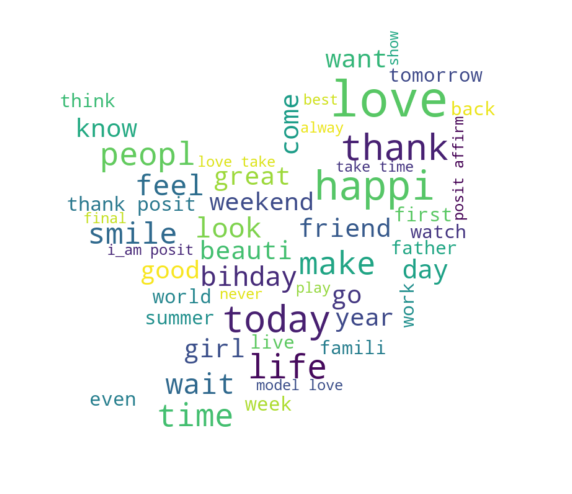

In [25]:
plot_wordcloud(all_words)

4. Visualize the wordcloud just for the text from the tweets identified as hate speech. 

    Similarly, you need to stitch all the tidy tweets in training set that were identified as hate speech. 
    Save the long string to `negative_words`.

In [26]:
negative_words = ' '.join(raw[raw['label']==1]['tidy_tweet'].tolist())

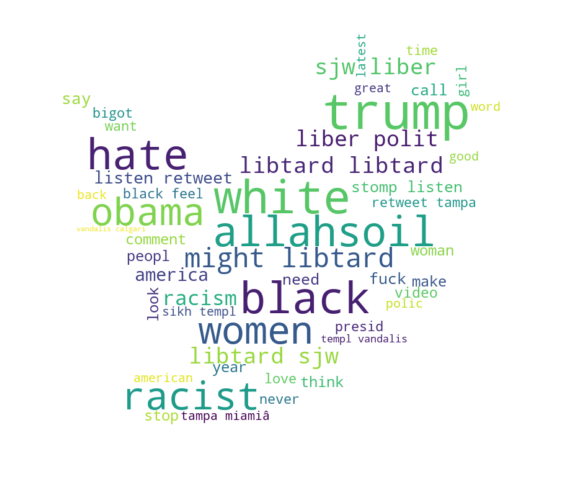

In [27]:
plot_wordcloud(negative_words)

5. Hashtag is a feature for tweets and we would like to inspect if hashtags provide information for our classification task. 

    Function `hashtag_extract` is provided to extract hastags from an iterable (list or series) and return the hashtags in a list. 

In [28]:
def hashtag_extract(x) -> list:
    """
    extract hastags from an iterable (list or series) and 
    return the hashtags in a list.
    """
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags

6. Extract hashtags from non-hate speech tweets.

In [29]:
HT_regular = hashtag_extract(raw[raw['label']==0]['tidy_tweet'].tolist()) # only keep non-hate tweets

In [30]:
assert type(HT_regular) == list
assert type(HT_regular[0]) == list # nested list

In [31]:
HT_regular[1:3]

[['lyft', 'disapoint', 'getthank'], []]

7. Now extract hashtags from hate speech tweets.

In [32]:
HT_negative = hashtag_extract(raw[raw['label']==1]['tidy_tweet'].tolist()) # only keep hate tweets

8. Both `HT_regular` and `HT_negative` are nested lists, so use the following trick to unnest both lists.

In [33]:
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

In [34]:
assert type(HT_regular) == type(HT_negative) == list
assert type(HT_regular[0]) == type(HT_negative[0]) == str

9. Complete the function `top_hashtags` below to take a list of hashtags and return the top `n` hashtag keyword and its frequncy. 

In [35]:
from typing import List, Tuple
from collections import Counter
def top_hashtags(hashtags:List[str], n=10) -> List[Tuple[str, int]]:
    ''' Function to return the top n hashtags '''
    # YOUR CODE HERE
    counter = Counter(hashtags) # User collections library to efficiently count hashtag occurences
    return counter.most_common(n) # only return top n most common

1. Apply the function to the hashtag lists from the non-hate speech tweets and the hate speech tweets.

In [36]:
top_hashtags(HT_regular) # show top non-hate hashtags

[('love', 1586),
 ('posit', 909),
 ('smile', 638),
 ('healthi', 567),
 ('thank', 529),
 ('fun', 434),
 ('affirm', 423),
 ('life', 399),
 ('model', 374),
 ('summer', 362)]

In [37]:
top_hashtags(HT_negative) # show top hate hashtags

[('trump', 133),
 ('polit', 94),
 ('allahsoil', 92),
 ('liber', 81),
 ('libtard', 77),
 ('sjw', 74),
 ('retweet', 57),
 ('black', 46),
 ('miamiâ', 38),
 ('hate', 36)]

10. DISCUSS: are these hashtags making sense? should we include them as features or should we strip the # before tokenizing (that is, treat "#love" the same as "love")? why and why not?
          #YOUR ANSWER HERE
          Some of the hashtags are positive and some of them are negative, 
          they might be good indicator for a tweet to be either positive or negative and can act as feature.

# Task 3. Features

Note that almost all the machine learning related Python modules expect numerical presentation of data; thus we need to transform our text first.
We will experiment with bag of words, tf-idf, and word2vec.  

1. Convert the collection of text documents to a matrix of token counts.

    Check the [official documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). 
    
    Create an instance of `CountVectorizer` named `bow_vectorizer`, set `max_features` to be `MAX_FEATURES`.
    Learn the vocabulary dictionary and return document-term matrix and save it to `bow_train`. Use `.fit_transform`. 

In [38]:
from sklearn.feature_extraction.text import CountVectorizer
MAX_FEATURES = 1000


bow_vectorizer = CountVectorizer(max_features=MAX_FEATURES) # initiate Count Vectorizer with max features
bow_train = bow_vectorizer.fit_transform(X_train) # fit Count vectorizer to X_train and return the document-term matrix

In [39]:
assert bow_train.shape == (X_train.shape[0], MAX_FEATURES)

2. Print the first three rows from `bow_train`. Hint: `.toarray()`.

In [40]:
# YOUR CODE HERE
bow_train[0:3].toarray() # show bag of words array

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [41]:
from scipy.sparse.csr import csr_matrix
assert type(bow_train) == csr_matrix

3. Similarly, convert the collection of text documents to a matrix of TF-IDF features.
    
    Create an instance of [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer) named `tfidf_vectorizer`, set `max_features` to be `MAX_FEATURES`.

    Learn the vocabulary and idf, return document-term matrix and save it to `tfidf_train`. 

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [43]:
tfidf_vectorizer = TfidfVectorizer(max_features=MAX_FEATURES, stop_words='english')  # stop_words 'english' includes all english stopwords for words
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

In [44]:
assert type(tfidf_train) == csr_matrix
assert tfidf_train.shape == bow_train.shape == (X_train.shape[0], MAX_FEATURES)

4. Extract word embeddings using Word2Vec. 
We will use [`gensim`](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html) for this task. 
    
    The Word2Vec model takes either a list of lists of tokens or an iterable that streams the sentences directly from disk/network. 
    Here, we tokenize the tidy tweets in `X_train` and save the list (`pd.series`) of lists of tokens to `tokenized_tweet`. 

In [45]:
tokenized_tweet = pd.Series(data=X_train.apply(lambda x: x.split())) # turn individual sentences into one long sentence

In [46]:
assert tokenized_tweet.shape == X_train.shape

In [47]:
tokenized_tweet.head()

id
1037     [like, spread, peanut, butter, white, bread, #...
2381     [watch, made, america, simpson, 30for30, inter...
31606    [franci, underwood, seen, leav, marseill, #nojok]
23438    [#enjoy, #music, #today, #free, #app, #free, #...
2670     [#juic, experi, #notsobad, #healthyliv, #eatcl...
Name: tidy_tweet, dtype: object

5. Import `Word2Vec` from `gensim.models`; see [doc](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec). 

    Create a skip-gram `Word2Vec` instance named `w2v` that learns on the `tokenized_tweet`, with `vector_size` set at `MAX_FEATURES`, and other parameters are provided. 

In [48]:
from gensim.models import Word2Vec

In [49]:
w2v = Word2Vec(
        # YOUR CODE HERE
        # YOUR CODE HERE
        tokenized_tweet,
        vector_size=MAX_FEATURES,
        window=5, min_count=2, sg = 1, 
        hs = 0, negative = 10,  workers= 2, 
        seed = 34)

6. Train the skip-gram model, set the epochs at 20.

In [ ]:
%%time
# YOUR CODE HERE
w2v.train(tokenized_tweet,total_examples=w2v.corpus_count,epochs=20) # train word2vec model

CPU times: user 1min 37s, sys: 186 ms, total: 1min 37s
Wall time: 1min


(2737828, 3222020)

In [50]:
w2v.corpus_count

23971

7. Let's see how the model performs. 
Specify a word and print out the 10 most similar words from the our tweets in the training set. 
Use [`most_similar`](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.most_similar). 
Hint: print the type of `w2v` and `w2v.wv`.

In [51]:
# YOUR CODE HERE
w2v.wv.most_similar(positive=['love']) # give back words most similar to love

[('time', 0.916601300239563),
 ('take', 0.905296266078949),
 ('children', 0.8986847400665283),
 ('#model', 0.8863409757614136),
 ('moment', 0.8862237930297852),
 ('sometim', 0.8812617063522339),
 ('dream', 0.8673384785652161),
 ('spend', 0.8637014031410217),
 ('walk', 0.8631041049957275),
 ('laugh', 0.857864499092102)]

In [52]:
w2v.wv.most_similar(positive=['trump']) # give back words most similar to love

[('obama', 0.9803287386894226),
 ('racist', 0.9781089425086975),
 ('presid', 0.9694691896438599),
 ('suppoer', 0.9677251577377319),
 ('women', 0.9660029411315918),
 ('vote', 0.9618368744850159),
 ('america', 0.9613199830055237),
 ('terrorist', 0.9584705829620361),
 ('histori', 0.9539000391960144),
 ('comment', 0.9519358277320862)]

8. Discuss: how does w2v calculate the similarities? 

  YOUR ANSWER HERE

Word vectors are positioned in the vector space such that words that share common contexts in the corpus are located in close proximity to one another in the vector space. For skip-grams specifically, it predicts the surrounding context words from the target words (inverse of Continuous Bag-of-Words). CBOW predicts target words (e.g. ‘mat’) from the surrounding context words (‘the cat sits on the’).

9. Discuss: do you think Word2Vec is supervised or unsupervised ML technique?

    YOUR ANSWER HERE

It is a self-supervised learning, as it learns from the target word.

Self-supervised learning (or self-supervision) is a ML technique where the training data is autonomously (or automatically) labeled. 


10. Engineer features. 

    For each tweet, we calculate the average of embeddings (function `word_vector`) and then apply it to every tidy tweet in `X_train` (use function `tokens_to_array`).
    Both functions are provided, inspect the code and save the features in `w2v_train`.

In [53]:
from gensim.models.keyedvectors import KeyedVectors

def word_vector(tokens:list, size:int, keyed_vec:KeyedVectors= w2v.wv):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += keyed_vec[word].reshape((1, size))
            count += 1
        except KeyError: 
            # handling the case where the token is not in vocabulary        
            continue
    if count != 0:
        vec /= count
    return vec

def tokens_to_array(tokens:list, size:int, keyed_vec:KeyedVectors= w2v.wv):
    array = np.zeros((len(tokens), size))
    for i in range(len(tokens)):
        array[i,:] = word_vector(tokens.iloc[i], size, keyed_vec=keyed_vec)
    return array

In [54]:
w2v_train = tokens_to_array(tokens=tokenized_tweet,size=MAX_FEATURES)

In [55]:
assert w2v_train.shape == (X_train.shape[0], MAX_FEATURES)

11. Prepare the test data before modeling for each approach:


  - extract features from `X_test` using the bag of words approach; use `bow_vectorizer`
  - extract features from `X_test` using the tf-idf approach; use `tfidf_vectorizer`
  - extract features from `X_test` using Word2Vec embeddings; you need to first tokenized the tidy tweets in `X_test`, then convert the tokens to array of shape `(X_test.shape[0], MAX_FEATURES)`.

In [56]:
bow_test = bow_vectorizer.fit_transform(X_test)# make bag of words test set
tfidf_test = tfidf_vectorizer.fit_transform(X_test)# make tfidf test set

tokenized_tweet_test = pd.Series(data=X_test.apply(lambda x: x.split()))# tokenize tweet test
w2v_test = tokens_to_array(tokens=tokenized_tweet_test,size=MAX_FEATURES)# grab associations of tweet test and store it in an array


In [57]:
assert bow_test.shape == tfidf_test.shape == w2v_test.shape == (X_test.shape[0], MAX_FEATURES)

# Task 4. Naive Bayes classifiers

In this task, you will build a [naive Bayes](https://sebastianraschka.com/Articles/2014_naive_bayes_1.html) (here's another [ref](https://www.inf.ed.ac.uk/teaching/courses/inf2b/learnnotes/inf2b-learn07-notes-nup.pdf)), classifiers to identify the hate speech tweets using different sets of features from the last task, and evaluate their performances. 

In the era of deep learning, naive Bayes is useful due to its simplicity and reasonable performance, especially if there is not much training data available. A common interview question is "Why is naive Bayes naive?". 

We will use multi-variate Bernoulli naive Bayes [`BernoulliNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html); try other flavors of [naive Bayes](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.naive_bayes) if time permits. Code is pretty straightforward. 

1. Import `BernoulliNB` for modeling and `classification_report` for reporting performance. 

In [58]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report

2. Create an instance of  `BernoulliNB` named `BNBmodel`. 

    We can use it for all three feature sets.

In [59]:
BNBmodel = BernoulliNB() # create instance of BernoulliNB


3. Train the multi-variate Bernoulli naive Bayes using bag of words features and print the performance report.

In [60]:
BNBmodel.fit(bow_train,y_train)# train the model on bag of words

BernoulliNB()

In [61]:
print(classification_report(y_test,BNBmodel.predict(bow_test)))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94      7430
           1       0.14      0.10      0.12       561

    accuracy                           0.90      7991
   macro avg       0.54      0.53      0.53      7991
weighted avg       0.88      0.90      0.89      7991



4. Similarly, train the model using tf-idf features and print the performance report. 

    Is the performance expected? Why or why not?

In [62]:
BNBmodel.fit(tfidf_train,y_train) # train the model on tfidf
print(classification_report(y_test,BNBmodel.predict(tfidf_test)))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      7430
           1       0.19      0.19      0.19       561

    accuracy                           0.89      7991
   macro avg       0.57      0.56      0.57      7991
weighted avg       0.89      0.89      0.89      7991



5. Finally, train the model using Word2Vec embeddings and report the performance. 

In [63]:
# YOUR CODE HERE
# YOUR CODE HERE
BNBmodel.fit(w2v_train,y_train)# train the model on word2vec
print(classification_report(y_test,BNBmodel.predict(w2v_test)))


              precision    recall  f1-score   support

           0       0.99      0.73      0.84      7430
           1       0.19      0.86      0.31       561

    accuracy                           0.74      7991
   macro avg       0.59      0.79      0.58      7991
weighted avg       0.93      0.74      0.80      7991



6. Discuss the differences in performace using tf-idf vs skim-gram embeddings. 

    YOUR ANSWER HERE

The skim-gram embeddings performed better on 'hate' tweets. \


7. Examine a few tweets where the model(s) failed. 
What other features would you include in the next iteration?

    YOUR ANSWER HERE

In [64]:
X_test.head(5)

id
15656    true life tough sometim feel helpless heabreak...
21615     mate address argument rather #troll #staup #rude
3198        surpris read make betray #scifi #kindleunlimit
12315                                               father
8634                      #fathersday gift proud dad avail
Name: tidy_tweet, dtype: object

In [66]:
raw.iloc[[216]]

label                                              tweet  len_tweet  \
id                                                                         
217      0  @user will be here for a screening. i will mis...        128   

                                     tidy_tweet  
id                                               
217  screen miss sing song potp shock treatment

In [69]:
raw.iloc[[315]]

label                                              tweet  len_tweet  \
id                                                                         
316      0   @user come on @user ...you can do better than...        115   

                                    tidy_tweet  
id                                              
316  come better pleas shoe unnecessari stress

In [67]:
df = pd.DataFrame(y_test)
df['pred'] = BNBmodel.predict(w2v_test) # make label-pred table
df = df[df['label'] != df['pred']]
df.head(5)

label  pred
id                
21615      0     1
3198       0     1
26616      0     1
29342      0     1
9978       0     1

# Task 5. Bidirectional LSTM 

In this task, you will build a bidirectional LSTM (BiLSTM) model to detect tweets identified as hate speech, and visualize the embedding layer using Tensorboard projector. 

Why BiLSTM? LSTM, at its core, preserves information from inputs that has already passed through it using the hidden state. Unidirectional LSTM only preserves information of the past because the only inputs it has seen are from the past. BiLSTMs run inputs in both ways, one from past to future and one from future to past and show very good results as they can understand context better [ref](https://stackoverflow.com/questions/43035827/whats-the-difference-between-a-bidirectional-lstm-and-an-lstm).

1. Tokenizing and padding. 
    
    As LSTM expects every sentence to be of the same length, in addition to [`Tokenizer`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) with a given number of vocabulary `VOCAB_SIZE`, we need to [pad](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) shorter tweets with 0s until the length is `MAX_LEN` and truncate longer tweets to be exact `MAX_LEN` long. 
    
   Function `tokenize_pad_sequences` is provided except that you need to supply correct `num_words` and `filters`; do NOT filter `#`. 
   
   We feed the processed `tidy_tweet` to `tokenize_pad_sequences`, but one can perform the preprocessing steps in `Tokenizer` and apply it directly on the raw tweets.

In [70]:
VOCAB_SIZE = 25000  
MAX_LEN = 50

In [77]:
import tensorflow as tf
from tensorflow import keras

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

def tokenize_pad_sequences(text):
    '''
    tokenize the input text into sequences of integers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(
        num_words= VOCAB_SIZE,# number of words in vocab size
        filters= '!"$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',# keep the #
        lower=True, split=' ', oov_token='oov')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=MAX_LEN)

    return X, tokenizer

In [79]:
print('Before Tokenization & Padding \n', raw['tidy_tweet'][1])
X, tokenizer = tokenize_pad_sequences(raw['tidy_tweet'])
print('After Tokenization & Padding \n', X[0])
y = raw['label'].values

Before Tokenization & Padding 
 father dysfunct selfish drag kid dysfunct #run
After Tokenization & Padding 
 [  14 6576 2391 1673  208 6576  465    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


2. Let's split `X` into training and testing datasets, save 25% for testing. 
Then split training dataset into training and validation datasets, with 20% for validation. 
Set both `random_state` to be 42. 
Stratify both splits. 

In [81]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.20, random_state=42, stratify=y_train
    )

In [82]:
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (19176, 50) (19176,)
Validation Set -> (4795, 50) (4795,)
Test Set -> (7991, 50) (7991,)


3. Now build a sequential model:

    - an embedding layer
    - a bidirectional LSTM with 32 units and set `return_sequences=True` in LSTM
    - a global average pooling operation for temporal data
    - a dropout layer with 20% rate
    - a dense layer of 32 units and set the activation function to be ReLu
    - a dense layer of 1 unit and set the proper activation function for classification

In [83]:
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import GlobalAveragePooling1D
from keras.layers import Dropout
from keras.layers import Dense
# (layer imports)

EMBEDDING_DIM = 16   
model = Sequential([
    Embedding(input_dim=VOCAB_SIZE,output_dim=EMBEDDING_DIM,input_length=MAX_LEN),
    Bidirectional(layer=LSTM(units=32,return_sequences=True)),
    GlobalAveragePooling1D(),
    Dropout(rate=.2),
    Dense(units=32,activation='relu'),
    Dense(units=1,activation='sigmoid') #use sigmoid since output labels are 0 and 1
])

In [ ]:
model.summary()

4. Compile the model. 

    Fill in a proper loss function and use adam as the optimizer. 
    For metrics, include precision and recall in the metrics, in addition to accuracy. 

In [84]:
from keras.metrics import Precision, Recall
model.compile(
    loss='binary_crossentropy',
    optimizer='adam', 
    metrics=['accuracy',Precision(thresholds=.5),Recall(thresholds=.5)]
    ) 

5. Train the model for 10 epochs on training dataset with a  validation set.

In [85]:
EPOCHS=10
BATCH_SIZE = 32
history = model.fit(X_train, y_train,
                    validation_data= (X_val, y_val), # YOUR CODE HERE
                    batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=2)

Epoch 1/10
600/600 - 29s - loss: 0.2022 - accuracy: 0.9427 - precision: 0.7536 - recall: 0.2729 - val_loss: 0.1280 - val_accuracy: 0.9583 - val_precision: 0.7881 - val_recall: 0.5536 - 29s/epoch - 48ms/step
Epoch 2/10
600/600 - 8s - loss: 0.0824 - accuracy: 0.9738 - precision: 0.8575 - recall: 0.7517 - val_loss: 0.1185 - val_accuracy: 0.9612 - val_precision: 0.9032 - val_recall: 0.5000 - 8s/epoch - 13ms/step
Epoch 3/10
600/600 - 6s - loss: 0.0491 - accuracy: 0.9860 - precision: 0.9284 - recall: 0.8677 - val_loss: 0.1278 - val_accuracy: 0.9612 - val_precision: 0.7660 - val_recall: 0.6429 - 6s/epoch - 10ms/step
Epoch 4/10
600/600 - 7s - loss: 0.0333 - accuracy: 0.9904 - precision: 0.9518 - recall: 0.9093 - val_loss: 0.1553 - val_accuracy: 0.9629 - val_precision: 0.8559 - val_recall: 0.5655 - 7s/epoch - 12ms/step
Epoch 5/10
600/600 - 6s - loss: 0.0262 - accuracy: 0.9925 - precision: 0.9581 - recall: 0.9346 - val_loss: 0.1828 - val_accuracy: 0.9485 - val_precision: 0.6219 - val_recall: 0.6

6. Function `plot_graphs` is provided below to visualize how the performance of model progresses as a function of epoch. 

    Visualize accuracy and loss. 

In [86]:
def plot_graphs(history, metric):
  fig, ax = plt.subplots()
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  ax.set_xticks(range(EPOCHS))
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

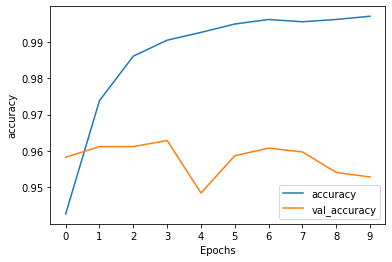

In [87]:
plot_graphs(history,'accuracy')# accuracy chart

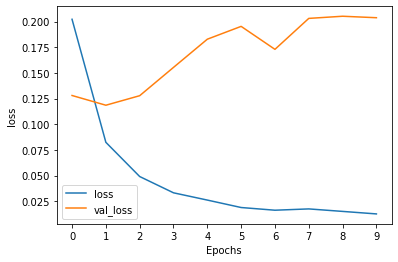

In [88]:
plot_graphs(history,'loss')# loss chart

7. The model starts to overfit after a couple of epochs. 
Consider using [early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) to stop training when a monitored metric has stopped improving. 

  What can we do to tame overfitting?

    YOUR ANSWER HERE

Early stopping is one technique we can use to tame overfitting. We can also increase the dropout rate. Additionally, we can add more tweets to our datasets.


8. Print the classification report of the model on test dataset. 

In [89]:
print(classification_report(y_test,(model.predict(X_test)>=.5)))# YOUR CODE HERE

250/250 [==============================] - 2s 3ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      7430
           1       0.66      0.65      0.65       561

    accuracy                           0.95      7991
   macro avg       0.81      0.81      0.81      7991
weighted avg       0.95      0.95      0.95      7991



9. Discuss: how does the BiLSTM model improve the classification over naive Bayes? 

    YOUR ANSWER HERE

In [90]:
# # NB using tf-idf
#               precision    recall  f1-score   support

#            0       0.96      0.97      0.97      7430
#            1       0.55      0.48      0.51       561

#     accuracy                           0.94      7991
#    macro avg       0.75      0.72      0.74      7991
# weighted avg       0.93      0.94      0.93      7991

# # NB using word2vec
#               precision    recall  f1-score   support

#            0       0.98      0.85      0.91      7430
#            1       0.29      0.82      0.43       561

#     accuracy                           0.85      7991
#    macro avg       0.64      0.83      0.67      7991
# weighted avg       0.94      0.85      0.88      7991

10. Visualize embeddings using [Embedding Projector](https://www.tensorflow.org/tensorboard/tensorboard_projector_plugin) in Tensorboard. 
The setup for Tensorboard can be tricky, most of the code is provided. 

    TensorBoard reads tensors and metadata from the logs of your tensorflow projects. 
    The path to the log directory is specified with log_dir below. 
    
    In order to load the data into Tensorboard, we need to save a training checkpoint to that directory, along with metadata that allows for visualization of a specific layer of interest in the model.

    Load the TensorBoard notebook extension and import `projector` from `tensorboard.plugins`.

In [91]:
%load_ext tensorboard

In [92]:
from tensorboard.plugins import projector

11. Clear any logs from previous runs if any.

In [93]:
rm -rf /logs/  

12. Set up a logs directory, so Tensorboard knows where to look for data.

In [94]:
import os
log_dir='/logs/tweets-example/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

13. Save the first `VOCAB_SIZE` most frequent words in the vocabulary as `metadata.tsv`.

In [95]:
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
  i = 0
  for label in tokenizer.word_index.keys():
    if label == 'oov':
      continue # skip oov
    f.write("{}\n".format(label))
    if i > VOCAB_SIZE:
      break
    i += 1

14. Save the weights we want to analyze as a variable. Note that the first value represents any unknown word, which is not in the metadata, here we will remove this value.

In [96]:
weights = tf.Variable(model.layers[0].get_weights()[0][1:]) # `embeddings` has a shape of (num_vocab, embedding_dim) 

15. Create a checkpoint from embedding, the filename and key are the name of the tensor.

In [97]:
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

'/logs/tweets-example/embedding.ckpt-1'

16. Set up config.

In [98]:
config = projector.ProjectorConfig()
embedding = config.embeddings.add()

17. The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`.

In [99]:
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

18. Verify the following files exist under the current directory

In [100]:
ls /logs/tweets-example/

checkpoint                            metadata.tsv
embedding.ckpt-1.data-00000-of-00001  projector_config.pbtxt
embedding.ckpt-1.index


19. Now run Tensorboard against on log data we just saved. 

    You may need to run this cell **twice** to see the projector correctly. 
    Use Chrome for least friction.

In [ ]:
%tensorboard --logdir /logs/tweets-example/

The TensorBoard Projector can be a great tool for interpreting and visualzing embedding. The dashboard allows users to search for specific terms, and highlights words that are adjacent to each other in the embedding (low-dimensional) space. Try a few word in the Search box and see if the embeddings make sense. 

# Task 6. Interpretation

Lastly let's try to understnad predictions by BiLSTM using a model agnostic approach -- [Local interpretable model-agnostic explanations (LIME)](https://christophm.github.io/interpretable-ml-book/lime.html)

1. Import `LimeTextExplainer` from the [`lime_text`](https://lime-ml.readthedocs.io/en/latest/lime.html#module-lime.lime_text) module in package [`lime`](https://github.com/marcotcr/lime)

In [102]:
from lime.lime_text import LimeTextExplainer

2. Create an instance of `LimeTextExplainer`, call it `explanier`. 

In [103]:
explainer = LimeTextExplainer(class_names=['no', 'yes'], random_state=2)

3. Method `explain_instance` expects the `classifier_fn` to be a function, we provide the function `predict_proba` as below. 

In [104]:
def predict_proba(arr):
    processed = tokenizer.texts_to_sequences(arr)
    processed = pad_sequences(processed, padding='post', maxlen=MAX_LEN)
    pred = model.predict(processed)
    r = []
    for i in pred:
        temp = i[0]
        r.append(np.array([1-temp,temp])) 
    return np.array(r)

4. Read about [`explain_instance`](https://lime-ml.readthedocs.io/en/latest/lime.html#lime.lime_text.LimeTextExplainer.explain_instance). 

    Create an instance named `exp` to explain the 16399th tidy tweet from the original dataset, i.e., `raw.tidy_tweet.iloc[16399]`. 

In [105]:
idx = 16399 
exp = explainer.explain_instance(
    raw.tidy_tweet.iloc[idx], # tweet
    classifier_fn=predict_proba,
    num_features=6)
exp.show_in_notebook(text=raw.tidy_tweet.iloc[idx])

157/157 [==============================] - 1s 4ms/step


5. Pick another random tweet and generate explanations for the prediction.

In [107]:
idx=1756
exp = explainer.explain_instance(
    raw.tidy_tweet.iloc[idx], # tweet
    classifier_fn=predict_proba,
    num_features=6)
exp.show_in_notebook(text=raw.tidy_tweet.iloc[idx])

157/157 [==============================] - 1s 5ms/step


In [ ]:
# YOUR CODE HERE

6. Jot down your observations in explaining the model. 

    YOUR ANSWER HERE

WRITING

# Acknowledgement & Reference

- Data is adapted from [Twitter sentiment analysis](https://datahack.analyticsvidhya.com/contest/practice-problem-twitter-sentiment-analysis/#ProblemStatement)
- [Twitter sentiment analysis](https://github.com/prateekjoshi565/twitter_sentiment_analysis/blob/master/code_sentiment_analysis.ipynb) 
- [Introduction to Word Embedding and Word2Vec](https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa)
- [When to use GRU over LSTM?](https://datascience.stackexchange.com/questions/14581/when-to-use-gru-over-lstm)
- Use a trained Word2Vec, Doc2Vec or FastTest embedding by `gensim` in buiding an embedding layers in Tensorflow, here's [how-to](https://github.com/RaRe-Technologies/gensim/wiki/Using-Gensim-Embeddings-with-Keras-and-Tensorflow).